#### Credit Scoring Model
* [SeriousDlqin2yrs] ----> (#Person experienced 90 days past due delinquency or worse (Target variable / label))
* [RevolvingUtilizationOfUnsecuredLines] ----> (#Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits)
* [age] ----> (#Age of borrower in years)
* [NumberOfTime30-59DaysPastDueNotWorse] ----> (#Number of times borrower has been 30-59 days past due but no worse in the last 2 years)
* [DebtRatio] ----> (#Monthly debt payments, alimony,living costs divided by monthy gross income)
* [MonthlyIncome] ----> (#Monthly income)
* [NumberOfOpenCreditLinesAndLoans] ----> (#Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)
* [NumberOfTimes90DaysLate] ----> (#Number of times borrower has been 90 days or more past due)
* [NumberRealEstateLoansOrLines] ----> (#Number of mortgage and real estate loans including home equity lines of credit)
* [NumberOfTime60-89DaysPastDueNotWorse] ----> (#Number of times borrower has been 60-89 days past due but no worse in the last 2 years)
* [NumberOfDependents] ----> (#Number of dependents in family excluding themselves (spouse, children etc.))

In [1]:
import numpy as np # linearna algebra
import pandas as pd # obdelava podatkov

#vizualizacija podatkov
%matplotlib inline 
import seaborn as sns 
import matplotlib.pyplot as plt

# ML Modeli:
from sklearn import svm
from sklearn.model_selection import cross_validate
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.neural_network import MLPClassifier

# Python utilities:
import time
import os

# Other
from collections import Counter
from scipy.stats import iqr
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, roc_auc_score
from sklearn.utils import class_weight
from sklearn.model_selection import GridSearchCV

#### 1) Uvoz in analiza podatkov

In [2]:
train = pd.read_csv(r"C:\Users\Miha\Desktop\Credit Scoring\cs-training.csv").drop('Unnamed: 0', axis = 1)
train.dtypes

SeriousDlqin2yrs                          int64
RevolvingUtilizationOfUnsecuredLines    float64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
MonthlyIncome                           float64
NumberOfOpenCreditLinesAndLoans           int64
NumberOfTimes90DaysLate                   int64
NumberRealEstateLoansOrLines              int64
NumberOfTime60-89DaysPastDueNotWorse      int64
NumberOfDependents                      float64
dtype: object

In [3]:
#test = pd.read_csv(r"C:\Users\Miha\Desktop\Credit Scoring\cs-test.csv").drop('Unnamed: 0', axis = 1)

In [4]:
train.rename(columns={'NumberOfTime30-59DaysPastDueNotWorse':'NumberOfTime30to59DaysPastDueNotWorse'}, inplace=True)
train.rename(columns={'NumberOfTime60-89DaysPastDueNotWorse':'NumberOfTime60to89DaysPastDueNotWorse'}, inplace=True)

In [5]:
train.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30to59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60to89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [6]:
train.shape

(150000, 11)

In [7]:
# preverim null vrednosti v tabeli
train.isnull().sum()

SeriousDlqin2yrs                             0
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30to59DaysPastDueNotWorse        0
DebtRatio                                    0
MonthlyIncome                            29731
NumberOfOpenCreditLinesAndLoans              0
NumberOfTimes90DaysLate                      0
NumberRealEstateLoansOrLines                 0
NumberOfTime60to89DaysPastDueNotWorse        0
NumberOfDependents                        3924
dtype: int64

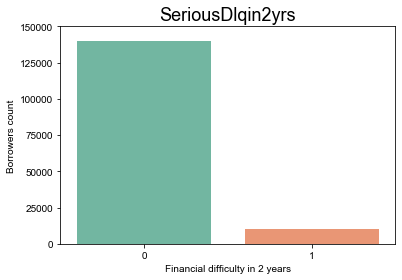

In [8]:
r = sns.countplot(x = train.SeriousDlqin2yrs , palette="Set2")
sns.set(font_scale=1.5)
r.set_ylim(top = len(train))
r.set_xlabel('Financial difficulty in 2 years')
r.set_ylabel('Borrowers count')
plt.title('SeriousDlqin2yrs')

plt.show()

#### 2) Iskanje ekstremov/izjem (Outlier detection)

###### Definicija:
In order to be an outlier, the data value must be:
* larger than Q3 by at least 1.5 times the interquartile range (IQR), or,
* smaller than Q1 by at least 1.5 times the IQR.

IQR = Q3 - Q1

In [9]:
train.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30to59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60to89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,0.066840,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,0.249746,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,1.000000,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


##### 2.1) Podrobnejša analiza RevolvingUtilizationOfUnsecuredLines -- obstajajo npr. vrednosti blizu 50000

In [10]:
# prikaz na kakšen način zgornji loop išče outliers-e
train.RevolvingUtilizationOfUnsecuredLines.describe()

count    150000.000000
mean          6.048438
std         249.755371
min           0.000000
25%           0.029867
50%           0.154181
75%           0.559046
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

In [11]:
Q3_ruul = np.percentile(train.RevolvingUtilizationOfUnsecuredLines,75)
IQR_ruul = iqr(train.RevolvingUtilizationOfUnsecuredLines)
Outlier_ruul = Q3_ruul + (1.5 * IQR_ruul)
Outlier_ruul

1.35281445575

In [12]:
train[train['RevolvingUtilizationOfUnsecuredLines'] > Outlier_ruul]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30to59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60to89DaysPastDueNotWorse,NumberOfDependents
226,1,1.953488,38,0,0.153500,3556.0,5,0,0,0,2.0
293,0,2340.000000,45,0,0.339333,8333.0,7,0,2,0,2.0
697,1,2066.000000,58,0,0.271121,6000.0,8,1,1,0,1.0
900,0,2.258964,33,2,0.032484,2000.0,1,1,0,0,2.0
919,1,1.362142,73,1,274.000000,NaN,2,3,0,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...
149245,0,771.000000,52,0,0.832021,8000.0,13,0,3,0,0.0
149279,0,20514.000000,42,0,0.062102,9902.0,1,1,0,0,2.0
149663,1,1.744511,49,0,1.224310,2500.0,4,4,2,1,1.0
149778,0,1.383886,26,2,0.247826,1839.0,3,1,0,1,0.0


Median: 0.1541807 
Mean: 6.0484381
Values less than Outlier_ruul: 149237 in 150000. Ratio: 99.49133%


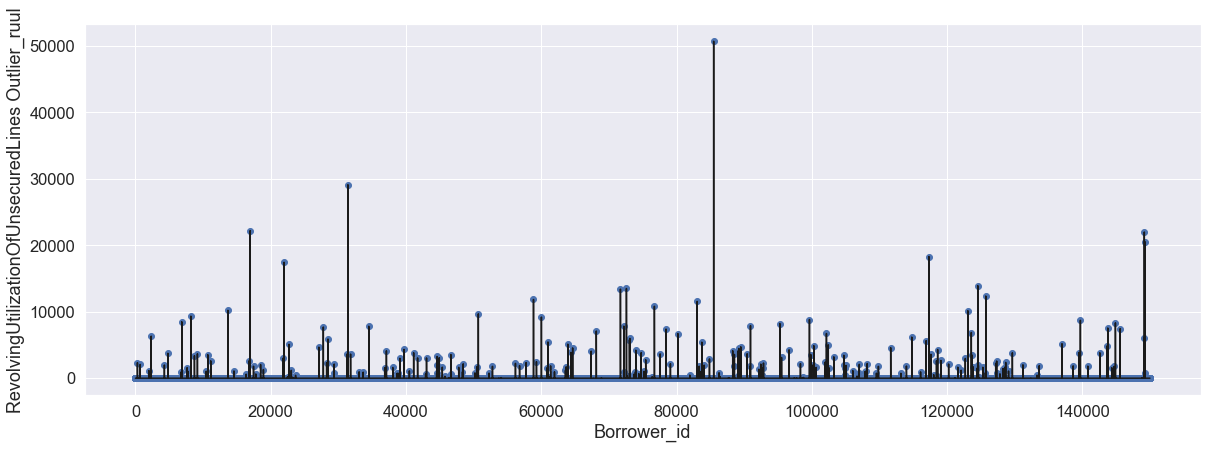

In [13]:
plt.figure(figsize=(20,15))
ax = plt.subplot(211)
plt.plot(train.RevolvingUtilizationOfUnsecuredLines, 'bo',train.RevolvingUtilizationOfUnsecuredLines, 'k')
print('Median: %.7f \nMean: %.7f' %(np.median(train.RevolvingUtilizationOfUnsecuredLines),np.mean(train.RevolvingUtilizationOfUnsecuredLines)))
ruoelLt2=len(train[train.RevolvingUtilizationOfUnsecuredLines < Outlier_ruul])
ruoelACt=len(train.RevolvingUtilizationOfUnsecuredLines)
print('Values less than Outlier_ruul: %d in %d. Ratio: %.5f%%' %(ruoelLt2,ruoelACt,100*ruoelLt2/ruoelACt))

plt.ylabel('RevolvingUtilizationOfUnsecuredLines Outlier_ruul')
plt.xlabel('Borrower_id')

plt.show()

###### Iz DF odstranim vse outliers-e

In [14]:
train[train['RevolvingUtilizationOfUnsecuredLines'] > Outlier_ruul]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30to59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60to89DaysPastDueNotWorse,NumberOfDependents
226,1,1.953488,38,0,0.153500,3556.0,5,0,0,0,2.0
293,0,2340.000000,45,0,0.339333,8333.0,7,0,2,0,2.0
697,1,2066.000000,58,0,0.271121,6000.0,8,1,1,0,1.0
900,0,2.258964,33,2,0.032484,2000.0,1,1,0,0,2.0
919,1,1.362142,73,1,274.000000,NaN,2,3,0,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...
149245,0,771.000000,52,0,0.832021,8000.0,13,0,3,0,0.0
149279,0,20514.000000,42,0,0.062102,9902.0,1,1,0,0,2.0
149663,1,1.744511,49,0,1.224310,2500.0,4,4,2,1,1.0
149778,0,1.383886,26,2,0.247826,1839.0,3,1,0,1,0.0


In [15]:
train = train[train['RevolvingUtilizationOfUnsecuredLines'] <= Outlier_ruul]

In [16]:
train.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30to59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60to89DaysPastDueNotWorse,NumberOfDependents
count,149237.000000,149237.000000,149237.000000,149237.000000,149237.000000,1.196900e+05,149237.000000,149237.000000,149237.000000,149237.00000,145338.000000
mean,0.065607,0.316992,52.328317,0.419661,353.169945,6.671913e+03,8.467525,0.262931,1.019834,0.23925,0.756808
std,0.247595,0.349765,14.771752,4.202747,2041.380555,1.441249e+04,5.147660,4.177966,1.130284,4.16522,1.114842
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,0.029579,41.000000,0.000000,0.175182,3.400000e+03,5.000000,0.000000,0.000000,0.00000,0.000000
50%,0.000000,0.151895,52.000000,0.000000,0.366527,5.400000e+03,8.000000,0.000000,1.000000,0.00000,0.000000
75%,0.000000,0.549296,63.000000,0.000000,0.866580,8.250000e+03,11.000000,0.000000,2.000000,0.00000,1.000000
max,1.000000,1.352159,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.00000,20.000000


##### 2.2) Podrobnejša analiza age (outliers)

count    149237.000000
mean         52.328317
std          14.771752
min           0.000000
25%          41.000000
50%          52.000000
75%          63.000000
max         109.000000
Name: age, dtype: float64

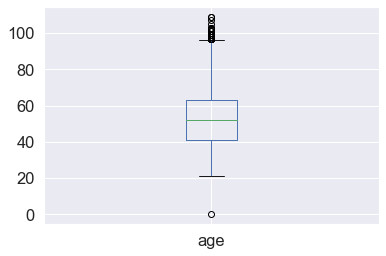

In [17]:
plt.figure(1)
train.age.plot.box()
Counter(train.age)
train.age.describe()

In [18]:
train.groupby('age').age.count()

age
0        1
21     182
22     430
23     637
24     811
      ... 
102      3
103      3
105      1
107      1
109      2
Name: age, Length: 86, dtype: int64

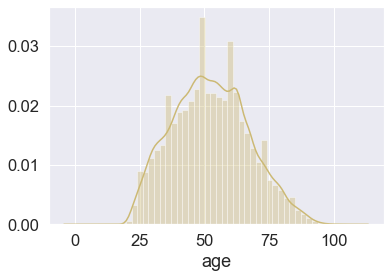

Outliers if age > 96.0


In [19]:
plt.figure(2)
sns.set_color_codes()
sns.distplot(train.age, color="y")
plt.show()

Q3_age = np.percentile(train.age,75)
IQR_age = iqr(train.age)
Outlier_age = Q3_age + (1.5 * IQR_age)
Outlier_age
print('Outliers if age >', Outlier_age) 

###### Dejansko ni večjih ekstremov - podatka "age" ne bom popravljal

##### 2.3) Podrobnejša analiza MonthlyIncome (outliers)

In [20]:
train.groupby('MonthlyIncome').MonthlyIncome.count()

MonthlyIncome
0.0          1629
1.0           604
2.0             6
4.0             2
5.0             2
             ... 
835040.0        1
1072500.0       1
1560100.0       1
1794060.0       1
3008750.0       1
Name: MonthlyIncome, Length: 13579, dtype: int64

###### Imamo tudi izjemno nizke, izredno visoke ter 'NA' vrednosti MonthlyIncome.

In [21]:
median_MonthlyIncome = train["MonthlyIncome"].astype("float").median(axis=0)
median_MonthlyIncome

5400.0

In [22]:
#NAN vrednosti nadomestim z mediano
train["MonthlyIncome"].replace(np.nan, median_MonthlyIncome, inplace=True)
#vrednosti med 0 in 10 nadomestim z mediano
train['MonthlyIncome'] = np.where(train['MonthlyIncome'].between(0,10), median_MonthlyIncome, train['MonthlyIncome'])

In [23]:
Q3_MonthlyIncome = np.percentile(train.MonthlyIncome,75)
IQR_MonthlyIncome = iqr(train.MonthlyIncome)
Outlier_MonthlyIncome = Q3_MonthlyIncome + (1.5 * IQR_MonthlyIncome)
Outlier_MonthlyIncome
print('Outliers if MonthlyIncome >', Outlier_MonthlyIncome) 

Outliers if MonthlyIncome > 12500.0


Median: 5400.0000000 
Mean: 6501.3917594


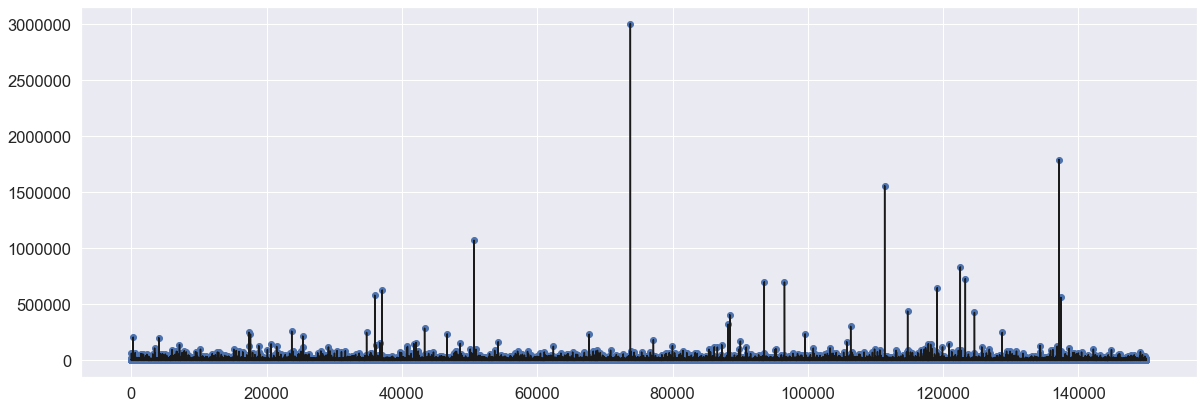

In [24]:
plt.figure(figsize=(20,15))
ax = plt.subplot(211)
plt.plot(train.MonthlyIncome, 'bo',train.MonthlyIncome, 'k')
print('Median: %.7f \nMean: %.7f' %(np.median(train.MonthlyIncome),np.mean(train.MonthlyIncome)))

###### Očitno gre res za posamezne mega zaslužkarje, zato teh podatkov ne bom spreminjal.

In [25]:
train.groupby('MonthlyIncome').MonthlyIncome.count()

MonthlyIncome
11.0         1
15.0         1
21.0         1
25.0         1
27.0         2
            ..
835040.0     1
1072500.0    1
1560100.0    1
1794060.0    1
3008750.0    1
Name: MonthlyIncome, Length: 13571, dtype: int64

##### 2.4) Podrobnejša analiza DebtRatio (outliers)

In [26]:
train.DebtRatio.describe()

count    149237.000000
mean        353.169945
std        2041.380555
min           0.000000
25%           0.175182
50%           0.366527
75%           0.866580
max      329664.000000
Name: DebtRatio, dtype: float64

In [27]:
Q3_DebtRatio = np.percentile(train.DebtRatio,75)
IQR_DebtRatio = iqr(train.DebtRatio)
Outlier_DebtRatio = Q3_DebtRatio + (1.5 * IQR_DebtRatio)
Outlier_DebtRatio
print('Outliers if DebtRatio >', Outlier_DebtRatio) 

Outliers if DebtRatio > 1.9036756469999998


Median: 0.3665267 
Mean: 353.1699453
Values less than Outlier_DebtRatio : 149237 in 149237. Ratio: 100.00000%


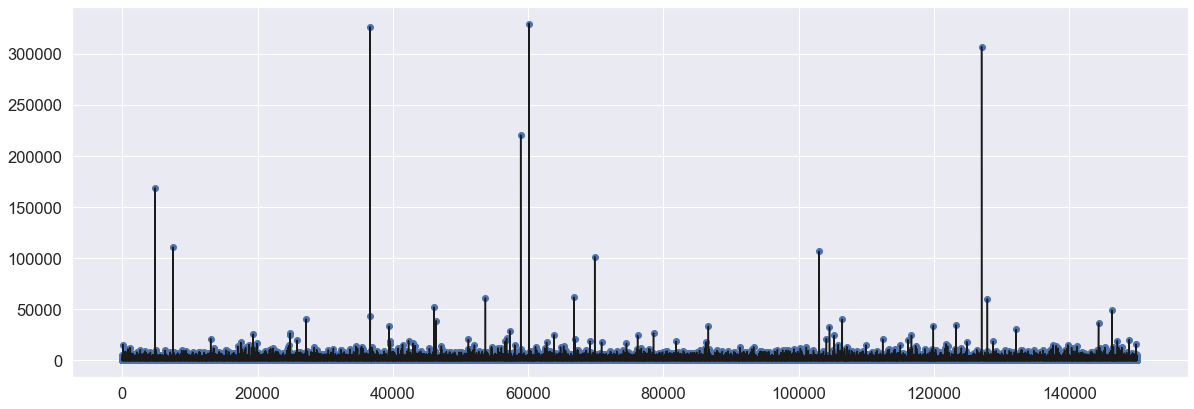

In [28]:
plt.figure(figsize=(20,15))
ax = plt.subplot(211)
#ax.set_ylim(0,20)
plt.plot(train.DebtRatio, 'bo',train.DebtRatio, 'k')
print('Median: %.7f \nMean: %.7f' %(np.median(train.DebtRatio),np.mean(train.DebtRatio)))
ruoelLt2=len(train[train.RevolvingUtilizationOfUnsecuredLines < Outlier_DebtRatio])
ruoelACt=len(train.RevolvingUtilizationOfUnsecuredLines)
print('Values less than Outlier_DebtRatio : %d in %d. Ratio: %.5f%%' %(ruoelLt2,ruoelACt,100*ruoelLt2/ruoelACt))

In [29]:
train.DebtRatio.quantile([.975])

0.975    3491.0
Name: DebtRatio, dtype: float64

Glede na podatke, 2,5 % dolžnikov dolguje cca 3500 krat več, kot imajo premoženja. Tole je sumljivo, oz. je potrebna nadaljna raziskava (ali so to outliers?)

In [30]:
#train[train['DebtRatio'] > 3491] # 3729 rows
#train[train['DebtRatio'] > 3491][['SeriousDlqin2yrs','MonthlyIncome']].describe()
train2 = train[train['DebtRatio'] > 3491]
train2.describe()
train2[train2['MonthlyIncome'] != median_MonthlyIncome]
train2[train2['DebtRatio'] > 3491][['SeriousDlqin2yrs','MonthlyIncome']].describe()

,SeriousDlqin2yrs,MonthlyIncome
count,3729.000000,3729.0
mean,0.063824,5400.0
std,0.244472,0.0
min,0.000000,5400.0
25%,0.000000,5400.0
50%,0.000000,5400.0
75%,0.000000,5400.0
max,1.000000,5400.0


In [31]:
train[(train['DebtRatio'] > 3491) & (train['SeriousDlqin2yrs'] == 0)]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30to59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60to89DaysPastDueNotWorse,NumberOfDependents
6,0,0.305682,57,0,5710.0,5400.0,8,0,3,0,0.0
90,0,0.039388,51,0,15466.0,5400.0,7,0,0,0,0.0
109,0,0.041258,61,0,4739.0,5400.0,11,0,4,0,NaN
124,0,0.277957,39,0,4090.0,5400.0,9,0,2,0,0.0
235,0,0.000000,66,0,3730.0,5400.0,8,0,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149923,0,0.245212,62,0,3720.0,5400.0,16,0,2,0,0.0
149932,0,0.807021,59,0,5467.0,5400.0,19,0,2,0,0.0
149958,0,0.457101,63,0,4945.0,5400.0,9,0,1,0,0.0
149992,0,0.871976,50,0,4132.0,5400.0,11,0,1,0,3.0


Očitno so problem podatki. Gre za podatke, ki niso imeli nastavljen MonthlyIncome oz. je bil le-ta < 10 (te sem popravil na median_MonthlyIncome) Lahko jih označim kot Outliers oz. jih brišem.

###### Iz DF odstranim DebtRatio outliers-e

In [32]:
train = train[train['DebtRatio'] < 3491]

Median: 0.3560209 
Mean: 210.3698257
Values less than Outlier_DebtRatio : 145504 in 145504. Ratio: 100.00000%


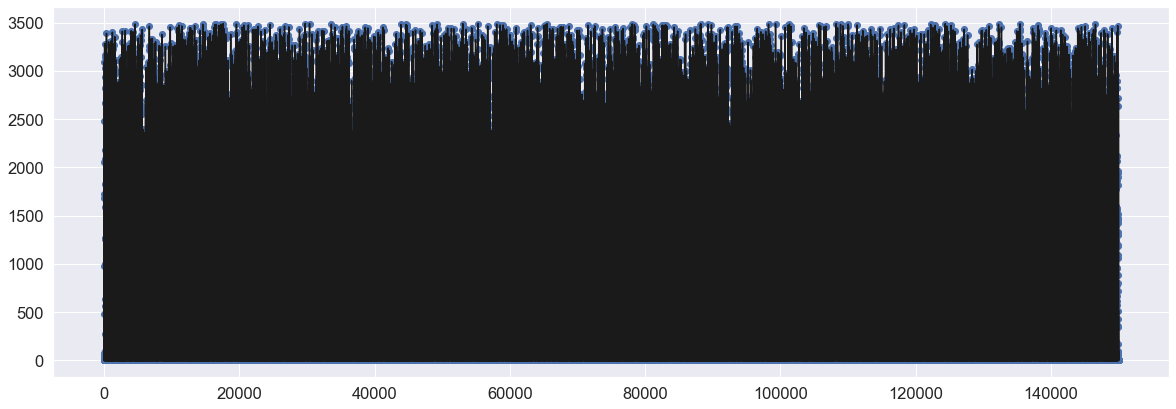

In [33]:
plt.figure(figsize=(20,15))
ax = plt.subplot(211)
#ax.set_ylim(0,20)
plt.plot(train.DebtRatio, 'bo',train.DebtRatio, 'k')
print('Median: %.7f \nMean: %.7f' %(np.median(train.DebtRatio),np.mean(train.DebtRatio)))
ruoelLt2=len(train[train.RevolvingUtilizationOfUnsecuredLines < Outlier_DebtRatio])
ruoelACt=len(train.RevolvingUtilizationOfUnsecuredLines)
print('Values less than Outlier_DebtRatio : %d in %d. Ratio: %.5f%%' %(ruoelLt2,ruoelACt,100*ruoelLt2/ruoelACt))

##### 2.5) Podrobnejša analiza NumberOfTimes90DaysLate (outliers)

In [34]:
train.groupby('NumberOfTimes90DaysLate').NumberOfTimes90DaysLate.count()
#sorted(Counter(train.NumberOfTimes90DaysLate))
#Counter(train.NumberOfTimes90DaysLate)

NumberOfTimes90DaysLate
0     137538
1       5067
2       1472
3        619
4        263
5        118
6         70
7         33
8         17
9         18
10         8
11         4
12         2
13         2
14         2
15         1
17         1
96         5
98       264
Name: NumberOfTimes90DaysLate, dtype: int64

Zanimiva ugotovitev je, da med 17 in 96 ni vrednosti NumberOfTimes90DaysLate, za vrednost 98 pa kar 264 primerov. Gre za napako na podatkih?

In [35]:
train[train['NumberOfTimes90DaysLate'] > 95][['SeriousDlqin2yrs','NumberOfTime60to89DaysPastDueNotWorse','NumberOfTime30to59DaysPastDueNotWorse','NumberOfTimes90DaysLate']].describe()

,SeriousDlqin2yrs,NumberOfTime60to89DaysPastDueNotWorse,NumberOfTime30to59DaysPastDueNotWorse,NumberOfTimes90DaysLate
count,269.000000,269.000000,269.000000,269.000000
mean,0.546468,97.962825,97.962825,97.962825
std,0.498764,0.270628,0.270628,0.270628
min,0.000000,96.000000,96.000000,96.000000
25%,0.000000,98.000000,98.000000,98.000000
50%,1.000000,98.000000,98.000000,98.000000
75%,1.000000,98.000000,98.000000,98.000000
max,1.000000,98.000000,98.000000,98.000000


Podatki ne zgledajo napačni, vendar bom vrednost vseeno spremenil na 18 oz 19, da ne bo tak ekstrem. To bi namreč lahko povzročilo slabši model pri algoritmih, ki so občutljivi na ekstreme - npr. SVM (random forest s tem nima težav)

In [36]:
train["NumberOfTimes90DaysLate"].replace(96, 18, inplace = True)
train["NumberOfTimes90DaysLate"].replace(98, 19, inplace = True)
#train.groupby('NumberOfTimes90DaysLate').NumberOfTimes90DaysLate.count()
train.NumberOfTimes90DaysLate.describe()

count    145504.000000
mean          0.122327
std           0.937669
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          19.000000
Name: NumberOfTimes90DaysLate, dtype: float64

##### 2.6) Podrobnejša analiza NumberOfTime30to59DaysPastDueNotWorse ter NumberOfTime60to89DaysPastDueNotWorse (outliers)

In [37]:
#train.groupby('NumberOfTime30to59DaysPastDueNotWorse').NumberOfTime30to59DaysPastDueNotWorse.count()
#train.groupby('NumberOfTime60to89DaysPastDueNotWorse').NumberOfTime60to89DaysPastDueNotWorse.count()

#naredim enako akcijo kot pri 2.4.. Vrednosti 96%98 spremenim v 18&19
train["NumberOfTime30to59DaysPastDueNotWorse"].replace(96, 18, inplace = True)
train["NumberOfTime30to59DaysPastDueNotWorse"].replace(98, 19, inplace = True)
train["NumberOfTime60to89DaysPastDueNotWorse"].replace(96, 18, inplace = True)
train["NumberOfTime60to89DaysPastDueNotWorse"].replace(98, 19, inplace = True)

In [38]:
#train.groupby('NumberOfOpenCreditLinesAndLoans').NumberOfOpenCreditLinesAndLoans.count()
#train.groupby('NumberOfTime30to59DaysPastDueNotWorse').NumberOfTime30to59DaysPastDueNotWorse.count()
train.groupby('NumberOfTime60to89DaysPastDueNotWorse').NumberOfTime60to89DaysPastDueNotWorse.count()

NumberOfTime60to89DaysPastDueNotWorse
0     138266
1       5486
2       1033
3        298
4         95
5         32
6         15
7          6
8          2
9          1
11         1
18         5
19       264
Name: NumberOfTime60to89DaysPastDueNotWorse, dtype: int64

##### 2.7) Podrobnejša analiza NumberOfDependents (outliers)

In [39]:
train.groupby('NumberOfDependents').NumberOfDependents.count()

NumberOfDependents
0.0     83958
1.0     25849
2.0     19031
3.0      9237
4.0      2788
5.0       730
6.0       156
7.0        51
8.0        24
9.0         4
10.0        4
13.0        1
20.0        1
Name: NumberOfDependents, dtype: int64

In [40]:
train.isnull().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30to59DaysPastDueNotWorse       0
DebtRatio                                   0
MonthlyIncome                               0
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60to89DaysPastDueNotWorse       0
NumberOfDependents                       3670
dtype: int64

###### 3670 strank ima null vrednost NumberOfDependents. Predvidevam, da so vrednosti prazne, ker nimajo družinskih članov, zato null vrednosti spremenim v 0.

In [41]:
#null vrednost zamenjam z 0
train["NumberOfDependents"].fillna(0, inplace = True)
#NAN vrednosti nadomestim z 0
train["NumberOfDependents"].replace(np.nan, 0, inplace=True)

##### 2.8) Podrobnejša analiza NumberOfOpenCreditLinesAndLoans (outliers)

In [42]:
train.groupby('NumberOfOpenCreditLinesAndLoans').NumberOfOpenCreditLinesAndLoans.count()

NumberOfOpenCreditLinesAndLoans
0      1880
1      4384
2      6546
3      8895
4     11393
5     12681
6     13307
7     12897
8     12191
9     10995
10     9298
11     8040
12     6729
13     5408
14     4335
15     3484
16     2859
17     2249
18     1771
19     1341
20     1097
21      809
22      648
23      499
24      388
25      307
26      220
27      183
28      143
29      106
30       83
31       69
32       51
33       43
34       33
35       25
36       18
37        7
38       12
39        9
40       10
41        4
42        8
43        7
44        2
45        8
46        3
47        2
48        6
49        4
50        2
51        2
52        3
53        1
54        4
56        2
57        2
58        1
Name: NumberOfOpenCreditLinesAndLoans, dtype: int64

In [43]:
Q3_NoOCLaL = np.percentile(train.NumberOfOpenCreditLinesAndLoans,75)
IQR_Q3_NoOCLaL = iqr(train.NumberOfOpenCreditLinesAndLoans)
Outlier_Q3_NoOCLaL = Q3_NoOCLaL + (3 * IQR_Q3_NoOCLaL) # namesto 1.5 sem podal 3 (izločim manj otliers-ov)
Outlier_Q3_NoOCLaL
print('Outliers if NumberOfOpenCreditLinesAndLoans >', Outlier_Q3_NoOCLaL) 

Outliers if NumberOfOpenCreditLinesAndLoans > 29.0


In [44]:
#naredim enako akcijo kot pri 2.4.. Vrednosti > 29 spremenim v 30
##train['NumberOfOpenCreditLinesAndLoans'] = np.where(train['NumberOfOpenCreditLinesAndLoans'].between(29,60), 30, train['NumberOfOpenCreditLinesAndLoans'])

In [45]:
#train.groupby('NumberOfOpenCreditLinesAndLoans').NumberOfOpenCreditLinesAndLoans.count().tail()

###### !!!!!ne bom spreminjal - niso takšni ekstremi

##### 2.9) Podrobnejša analiza NumberRealEstateLoansOrLines (outliers)

In [46]:
train.groupby('NumberRealEstateLoansOrLines').NumberRealEstateLoansOrLines.count()

NumberRealEstateLoansOrLines
0     55732
1     51192
2     29788
3      5646
4      1881
5       590
6       282
7       140
8        78
9        62
10       33
11       16
12       17
13       14
14        7
15        5
16        4
17        3
18        1
19        2
20        2
21        1
23        1
25        3
26        1
29        1
32        1
54        1
Name: NumberRealEstateLoansOrLines, dtype: int64

In [47]:
Q3_NoRELaL = np.percentile(train.NumberRealEstateLoansOrLines,75)
IQR_Q3_NoRELaL = iqr(train.NumberRealEstateLoansOrLines)
Outlier_Q3_NoRELaL = Q3_NoRELaL + (6 * IQR_Q3_NoRELaL) # namesto 1.5 sem podal 3 (izločim manj otliers-ov)
Outlier_Q3_NoRELaL
print('Outliers if NumberRealEstateLoansOrLines >', Outlier_Q3_NoRELaL) 

Outliers if NumberRealEstateLoansOrLines > 14.0


###### !!!!!ne bom spreminjal NumberRealEstateLoansOrLines - niso takšni ekstremi

#### 3) Korelacija med spremenljivkami

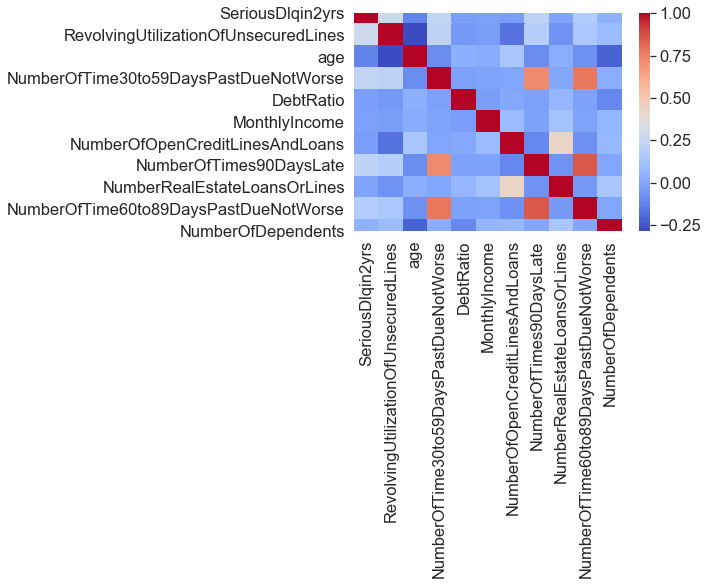

In [48]:
g = sns.heatmap(train.corr(),annot=False, fmt = ".2f", cmap = "coolwarm")

###### Vidimo lahko, da ima target spremenljivka 'SeriousDlqin2yrs' največjo korelacijo z RevolvingUtilizationOfUnsecuredLines, NumberOfDependents ter ostalimi oblikami zamujenih odplačil.

#### 4) Model

In [49]:
outcome_feature = train['SeriousDlqin2yrs']
target_features = train.drop('SeriousDlqin2yrs', axis=1)

#outcome_feature = train.loc[:, train.columns=='SeriousDlqin2yrs']
#target_features = train.loc[:, train.columns!='SeriousDlqin2yrs']


X_train, X_test, Y_train, Y_test = train_test_split(target_features, outcome_feature, test_size=0.2)

In [50]:
print('X_train_lenght =', len(X_train))
print('Y_train_lenght =', len(Y_train))
print('X_test_lenght =', len(X_test))
print('Y_test_lenght =', len(Y_test))

X_train_lenght = 116403
Y_train_lenght = 116403
X_test_lenght = 29101
Y_test_lenght = 29101


In [51]:
# porazdelitev vrednosti odvisne spremenljivke
#Y_train.value_counts(normalize=True),2
Y_test.value_counts()

0    27198
1     1903
Name: SeriousDlqin2yrs, dtype: int64

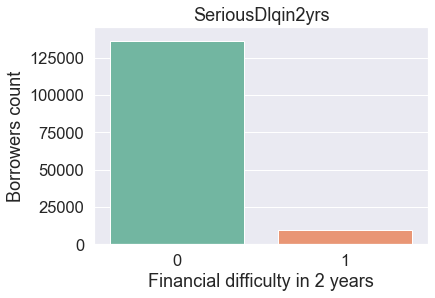

In [52]:
r = sns.countplot(x = train.SeriousDlqin2yrs , palette="Set2")
sns.set(font_scale=1.5)
r.set_ylim(top = len(train))
r.set_xlabel('Financial difficulty in 2 years')
r.set_ylabel('Borrowers count')
plt.title('SeriousDlqin2yrs')

plt.show()

##### 4.1) DecisionTreeClassifier

In [53]:
clf_dt = tree.DecisionTreeClassifier(class_weight='balanced',max_depth=6,min_impurity_decrease=0.0)
clf_dt.fit(X_train,Y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [54]:
Y_pred_dt = clf_dt.predict(X_test)
pd.crosstab(Y_test, Y_pred_dt, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,21615,5583,27198
1,461,1442,1903
All,22076,7025,29101


In [55]:
accuracy_score(Y_test, Y_pred_dt)

0.7923095426274012

In [56]:
print(classification_report(Y_test, Y_pred_dt))

              precision    recall  f1-score   support

           0       0.98      0.79      0.88     27198
           1       0.21      0.76      0.32      1903

    accuracy                           0.79     29101
   macro avg       0.59      0.78      0.60     29101
weighted avg       0.93      0.79      0.84     29101



##### 4.2) LogisticRegression

In [57]:
clf_lr = linear_model.LogisticRegression(C=1e5,class_weight= {0:.1, 1:.9}, solver='liblinear')
clf_lr.fit(X_train,Y_train)

LogisticRegression(C=100000.0, class_weight={0: 0.1, 1: 0.9}, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [58]:
Y_pred_lr = clf_lr.predict(X_test)
netMat = (Y_pred_lr == Y_test)
clf_lr.coef_
ind = np.where(Y_test == 1)
Counter(Y_pred_lr[ind])
pd.crosstab(Y_test, Y_pred_lr, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,23929,3269,27198
1,697,1206,1903
All,24626,4475,29101


In [59]:
accuracy_score(Y_test, Y_pred_lr)

0.863716023504347

In [60]:
print(classification_report(Y_test, Y_pred_lr))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92     27198
           1       0.27      0.63      0.38      1903

    accuracy                           0.86     29101
   macro avg       0.62      0.76      0.65     29101
weighted avg       0.93      0.86      0.89     29101



In [61]:
def generate_auc_roc_curve_lr(clf_lr, X_test):
    Y_pred_lr = clf_lr.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test,  Y_pred_lr)
    auc_lr = roc_auc_score(Y_test, Y_pred_lr)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc_lr))
    plt.legend(loc=4)
    plt.show()
    pass

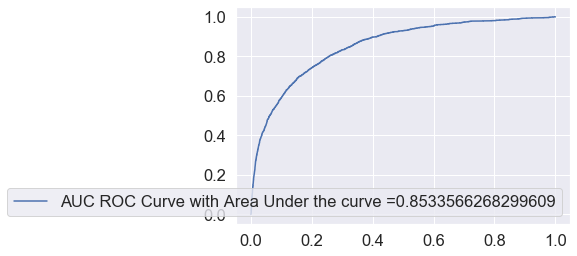

In [62]:
generate_auc_roc_curve_lr(clf_lr, X_test)

##### 4.3) Multilayer perceptron (NeuralNetwork)

In [63]:
clf_nn = MLPClassifier(activation="identity", tol= 0.1)
clf_nn.fit(X_train, Y_train)

MLPClassifier(activation='identity', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.1,
              validation_fraction=0.1, verbose=False, warm_start=False)

###### S spremembami threshold, lahko spreminjam precision in recall

In [64]:
threshold_nn = 0.2
predicted_proba_nn = clf_nn.predict_proba(X_test)

Y_pred_nn = (predicted_proba_nn [:,1] >= threshold_nn).astype('int')
pd.crosstab(Y_test, Y_pred_nn, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,23825,3373,27198
1,856,1047,1903
All,24681,4420,29101


In [65]:
accuracy_score(Y_test, Y_pred_nn)

0.8546785333837326

In [66]:
print(classification_report(Y_test, Y_pred_nn))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92     27198
           1       0.24      0.55      0.33      1903

    accuracy                           0.85     29101
   macro avg       0.60      0.71      0.62     29101
weighted avg       0.92      0.85      0.88     29101



##### 4.4) RandomForest

In [67]:
clf_rf = RandomForestClassifier(n_estimators=19, max_depth = 9, random_state=0)
clf_rf.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=19,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

##### S spremembami threshold, lahko spreminjam precision in recall

In [68]:
threshold_rf = 0.2
predicted_proba_rf = clf_rf.predict_proba(X_test)

Y_pred_rf = (predicted_proba_rf [:,1] >= threshold_rf).astype('int')

pd.crosstab(Y_test, Y_pred_rf, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,25646,1552,27198
1,925,978,1903
All,26571,2530,29101


In [69]:
accuracy_score(Y_test, Y_pred_rf)

0.9148826500807532

In [70]:
print(classification_report(Y_test, Y_pred_rf))

              precision    recall  f1-score   support

           0       0.97      0.94      0.95     27198
           1       0.39      0.51      0.44      1903

    accuracy                           0.91     29101
   macro avg       0.68      0.73      0.70     29101
weighted avg       0.93      0.91      0.92     29101



In [71]:
def generate_auc_roc_curve_rf(clf_rf, X_test):
    Y_pred_rf = clf_rf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test,  Y_pred_rf)
    auc_rf = roc_auc_score(Y_test, Y_pred_rf)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc_rf))
    plt.legend(loc=4)
    plt.show()
    pass

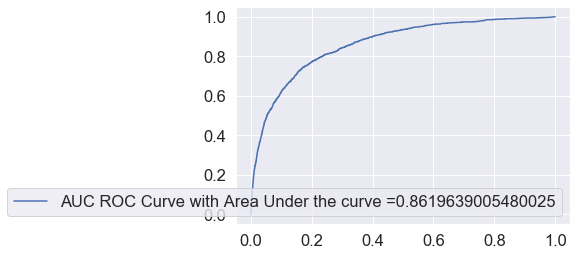

In [72]:
generate_auc_roc_curve_rf(clf_rf, X_test)

#### 5) Uravnoteženje porazdelitve odvisne spremenljivke (class_weight='balanced')

In [73]:
print('X_train_lenght =', len(X_train))
print('Y_train_lenght =', len(Y_train))
print('X_test_lenght =', len(X_test))
print('Y_test_lenght =', len(Y_test))

X_train_lenght = 116403
Y_train_lenght = 116403
X_test_lenght = 29101
Y_test_lenght = 29101


In [74]:
Y_test.value_counts()

0    27198
1     1903
Name: SeriousDlqin2yrs, dtype: int64

In [75]:
Y_train.value_counts()

0    108753
1      7650
Name: SeriousDlqin2yrs, dtype: int64

In [76]:
# porazdelitev vrednosti odvisne spremenljivke
Y_train.value_counts(normalize=True),2

(0    0.93428
 1    0.06572
 Name: SeriousDlqin2yrs, dtype: float64, 2)

In [77]:
unique_classes = list(train['SeriousDlqin2yrs'].unique())
unique_classes

[1, 0]

In [78]:
out_dict = {}
for classes in unique_classes:
    out_dict[classes] = train.shape[0]/((train.loc[train['SeriousDlqin2yrs'] == classes].shape[0])
                                     *len(unique_classes))

In [79]:
out_dict

{1: 7.6156181304302315, 0: 0.5351339820964907}

In [80]:
print (X_test.shape, Y_test.shape)

(29101, 10) (29101,)


##### 5.1) LogisticRegression (class_weight='balanced')

In [81]:
clf_lr_2 = linear_model.LogisticRegression(class_weight='balanced', solver='liblinear')
#clf_lr_2.fit(X_train,Y_train)
clf_lr_2.fit(X_train,Y_train.values.ravel())

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [82]:
class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)

array([0.53517144, 7.60803922])

In [83]:
Y_pred_lr_2 = clf_lr_2.predict(X_test)
pd.crosstab(Y_test, Y_pred_lr_2, rownames=['Actual'], colnames=['Predicted'], margins=True)
# pd.crosstab(pd.Series(Y_pred_lr_2, name = 'Predicted'),
#             pd.Series(Y_test['SeriousDlqin2yrs'], name = 'Actual'), margins=True)

Predicted,0,1,All
Actual,,,
0,21691,5507,27198
1,486,1417,1903
All,22177,6924,29101


In [84]:
len(Y_pred_lr_2)
len(Y_test)

29101

In [85]:
accuracy_score(Y_test, Y_pred_lr_2)

0.7940620597230336

In [86]:
print(classification_report(Y_test, Y_pred_lr_2))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88     27198
           1       0.20      0.74      0.32      1903

    accuracy                           0.79     29101
   macro avg       0.59      0.77      0.60     29101
weighted avg       0.93      0.79      0.84     29101



##### Iskanje optimalne nastavitve "weights"

In [87]:
weights = np.linspace(0.05, 0.95, 20)
gsc = GridSearchCV(
    estimator=LogisticRegression(solver='liblinear'),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=5
)

grid_result = gsc.fit(X_train, Y_train.values.ravel())
print("Best parameters : %s" % grid_result.best_params_)

C:\Users\Miha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Miha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Miha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Miha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Miha\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetri

Best parameters : {'class_weight': {0: 0.19210526315789472, 1: 0.8078947368421052}}


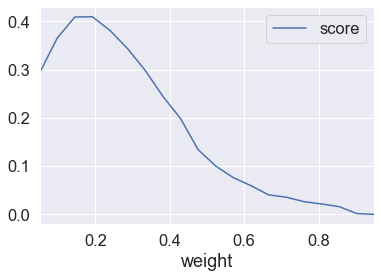

In [88]:
data_out = pd.DataFrame({'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
data_out.plot(x='weight')

In [89]:
print('max_data_out_score = ', max(data_out['score']))
data_out

## weight --> xxx

max_data_out_score =  0.40951128282148475


,score,weight
0,0.293050,0.050000
1,0.365262,0.097368
2,0.408940,0.144737
3,0.409511,0.192105
4,0.381009,0.239474
5,0.343170,0.286842
6,0.298096,0.334211
7,0.244490,0.381579
8,0.198600,0.428947
9,0.133976,0.476316


In [90]:
clf_lr_3 = linear_model.LogisticRegression(**grid_result.best_params_, solver='liblinear')
#clf_lr_2.fit(X_train,Y_train)
clf_lr_3.fit(X_train,Y_train.values.ravel())

LogisticRegression(C=1.0,
                   class_weight={0: 0.19210526315789472, 1: 0.8078947368421052},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None,
                   penalty='l2', random_state=None, solver='liblinear',
                   tol=0.0001, verbose=0, warm_start=False)

In [91]:
Y_pred_lr_3 = clf_lr_3.predict(X_test)
pd.crosstab(Y_test, Y_pred_lr_2, rownames=['Actual'], colnames=['Predicted'], margins=True)
# pd.crosstab(pd.Series(Y_pred_lr_3, name = 'Predicted'),
#             pd.Series(Y_test['SeriousDlqin2yrs'], name = 'Actual'), margins=True)

Predicted,0,1,All
Actual,,,
0,21691,5507,27198
1,486,1417,1903
All,22177,6924,29101


In [92]:
accuracy_score(Y_test, Y_pred_lr_3)

0.9258444726985327

In [93]:
print(classification_report(Y_test, Y_pred_lr_3))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     27198
           1       0.43      0.40      0.42      1903

    accuracy                           0.93     29101
   macro avg       0.69      0.68      0.69     29101
weighted avg       0.92      0.93      0.92     29101



##### 5.2) RandomForest (class_weight='balanced')

In [94]:
weights = np.linspace(0.05, 0.95, 20)
gsc_rf = GridSearchCV(
    estimator=RandomForestClassifier(n_estimators=19, max_depth = 9, random_state=0),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=5
)

grid_result = gsc_rf.fit(X_train, Y_train.values.ravel())
print("Best parameters : %s" % grid_result.best_params_)

Best parameters : {'class_weight': {0: 0.14473684210526316, 1: 0.8552631578947368}}


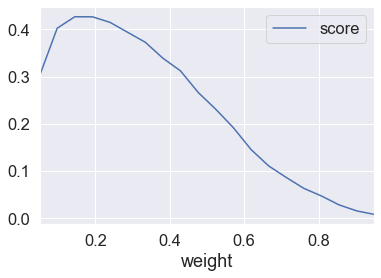

In [95]:
data_out = pd.DataFrame({'score': grid_result.cv_results_['mean_test_score'],
                         'weight': weights })
data_out.plot(x='weight')

In [96]:
print('max_data_out_score = ', max(data_out['score']))
data_out

## weight --> 0.192105

max_data_out_score =  0.42655915163143726


,score,weight
0,0.301394,0.050000
1,0.402297,0.097368
2,0.426559,0.144737
3,0.426401,0.192105
4,0.414652,0.239474
5,0.393596,0.286842
6,0.372577,0.334211
7,0.338811,0.381579
8,0.311920,0.428947
9,0.266436,0.476316


In [97]:
clf_rf_2 = RandomForestClassifier(**grid_result.best_params_, n_estimators=19, max_depth = 9, random_state=0)
#clf_lr_2.fit(X_train,Y_train)
clf_rf_2.fit(X_train,Y_train.values.ravel())

RandomForestClassifier(bootstrap=True,
                       class_weight={0: 0.14473684210526316,
                                     1: 0.8552631578947368},
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=19, n_jobs=None, oob_score=False,
                       random_state=0, verbose=0, warm_start=False)

In [127]:
threshold_rf_2 = 0.6
predicted_proba_rf_2 = clf_rf_2.predict_proba(X_test)

Y_pred_rf_2 = (predicted_proba_rf_2 [:,1] >= threshold_rf_2).astype('int')

pd.crosstab(Y_test, Y_pred_rf_2, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
Actual,,,
0,26001,1197,27198
1,1047,856,1903
All,27048,2053,29101


In [128]:
accuracy_score(Y_test, Y_pred_rf_2)

0.9228892477921721

In [129]:
print(classification_report(Y_test, Y_pred_rf_2))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     27198
           1       0.42      0.45      0.43      1903

    accuracy                           0.92     29101
   macro avg       0.69      0.70      0.70     29101
weighted avg       0.93      0.92      0.92     29101



In [122]:
def generate_auc_roc_curve_rf_2(clf_rf_2, X_test):
    Y_pred_rf_2 = clf_rf_2.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(Y_test,  Y_pred_rf_2)
    auc_rf_2 = roc_auc_score(Y_test, Y_pred_rf_2)
    plt.plot(fpr,tpr,label="AUC ROC Curve with Area Under the curve ="+str(auc_rf_2))
    plt.legend(loc=4)
    plt.show()
    pass

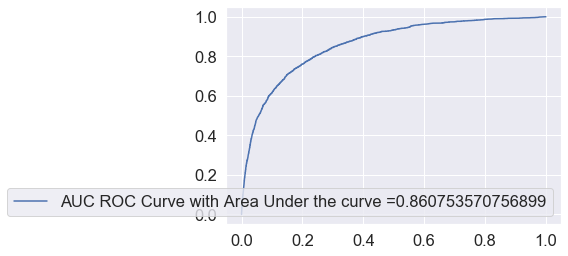

In [123]:
generate_auc_roc_curve_rf_2(clf_rf_2, X_test)

# THE END --- spodaj so le razne opombe, analize....

##### 2.10) končno generalno brisanje Outliers (kar še nisem uredil ročno)

##### Na ta način lahko enostavno najdem in nato odstranim outliers-e (tokrat sem jih že vse uredil ročno, kar je običajno bolje, saj včasih definicija outliers zazna preveč podatkov za izbris)

In [103]:
# def detect_outliers(train,n,features):
#     outlier_indices = []
    
#     # iterate over features(columns)
#     for col in features:
#         # 1st quartile (25%)
#         Q1 = np.percentile(train[col], 25)
#         # 3rd quartile (75%)
#         Q3 = np.percentile(train[col],75)
#         # Interquartile range (IQR)
#         IQR = Q3 - Q1
        
#         # outlier step
#         outlier_step = 1.5 * IQR
        
#         # Determine a list of indices of outliers for feature col
#         outlier_list_col = train[(train[col] < Q1 - outlier_step) | (train[col] > Q3 + outlier_step )].index
        
#         # append the found outlier indices for col to the list of outlier indices 
#         outlier_indices.extend(outlier_list_col)
        
#     # select observations containing more than 2 outliers
#     outlier_indices = Counter(outlier_indices)        
#     multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
#     return multiple_outliers

# # detect outliers from Age, SibSp , Parch and Fare
# # These are the numerical features present in the dataset
# Outliers_to_drop = detect_outliers(train,2,["RevolvingUtilizationOfUnsecuredLines",
#                                             "age",
#                                             "NumberOfTime30to59DaysPastDueNotWorse",
#                                             "DebtRatio",
#                                             "MonthlyIncome",
#                                             "NumberOfOpenCreditLinesAndLoans",
#                                             "NumberOfTimes90DaysLate",
#                                             "NumberRealEstateLoansOrLines",
#                                             "NumberOfTime60to89DaysPastDueNotWorse",
#                                             "Unnamed: 0",
#                                             "NumberOfDependents"])

##### Ureditev testne baze  ---> nima smisla, ker nimam rezultatov za testno bazo, posledično ne moremo preverjati

In [104]:
# ## UREDIM NA ENAK NAČIN KOT TRAIN DF
# test.rename(columns={'NumberOfTime30-59DaysPastDueNotWorse':'NumberOfTime30to59DaysPastDueNotWorse'}, inplace=True)
# test.rename(columns={'NumberOfTime60-89DaysPastDueNotWorse':'NumberOfTime60to89DaysPastDueNotWorse'}, inplace=True)


# test["NumberOfTimes90DaysLate"].replace(96, 18, inplace = True)
# test["NumberOfTimes90DaysLate"].replace(98, 19, inplace = True)
# test["NumberOfTime30to59DaysPastDueNotWorse"].replace(96, 18, inplace = True)
# test["NumberOfTime30to59DaysPastDueNotWorse"].replace(98, 19, inplace = True)
# test["NumberOfTime60to89DaysPastDueNotWorse"].replace(96, 18, inplace = True)
# test["NumberOfTime60to89DaysPastDueNotWorse"].replace(98, 19, inplace = True)

# #null vrednost zamenjam z 0
# test["NumberOfDependents"].fillna(0, inplace = True)
# #NAN vrednosti nadomestim z 0
# test["NumberOfDependents"].replace(np.nan, 0, inplace=True)

# #NAN vrednosti nadomestim z mediano
# median_MonthlyIncome2 = test["MonthlyIncome"].astype("float").median(axis=0)
# test["MonthlyIncome"].replace(np.nan, median_MonthlyIncome2, inplace=True)
# #vrednosti med 0 in 10 nadomestim z mediano
# test['MonthlyIncome'] = np.where(test['MonthlyIncome'].between(0,10), median_MonthlyIncome2, test['MonthlyIncome'])

#### 4) Testiranje modela

In [105]:
# class Tester():
#     def __init__(self, target):
#         self.target = target
#         self.datasets = {}
#         self.models = {}
#         self.cache = {} # we added a simple cache to speed things up

#     def addDataset(self, name, train):
#         self.datasets[name] = train.copy()

#     def addModel(self, name, model):
#         self.models[name] = model
        
#     def clearModels(self):
#         self.models = {}

#     def clearCache(self):
#         self.cache = {}
    
#     def testModelWithDataset(self, m_name, train_name, sample_len, cv):
#         if (m_name, train_name, sample_len, cv) in self.cache:
#             return self.cache[(m_name, train_name, sample_len, cv)]

#         clf = self.models[m_name]
        
#         if not sample_len: 
#             sample = self.datasets[train_name]
#         else: sample = self.datasets[train_name].sample(sample_len)
            
#         X = sample.drop([self.target], axis=1)
#         Y = sample[self.target]

#         s = cross_validate(clf, X, Y, scoring=['roc_auc'], cv=cv, n_jobs=-1)
#         self.cache[(m_name, train_name, sample_len, cv)] = s

#         return s

#     def runTests(self, sample_len=80000, cv=4):
#         # Tests the added models on all the added datasets
#         scores = {}
#         for m_name in self.models:
#             for train_name in self.datasets:
#                 # print('Testing %s' % str((m_name, train_name)), end='')
#                 start = time.time()

#                 score = self.testModelWithDataset(m_name, train_name, sample_len, cv)
#                 scores[(m_name, train_name)] = score
                
#                 end = time.time()
                
#                 # print(' -- %0.2fs ' % (end - start))

#         print('--- Top 10 Results ---')
#         for score in sorted(scores.items(), key=lambda x: -1 * x[1]['test_roc_auc'].mean())[:10]:
#             auc = score[1]['test_roc_auc']
#             print("%s --> AUC: %0.4f (+/- %0.4f)" % (str(score[0]), auc.mean(), auc.std()))

            
# # We will use a tester object across all models
# tester = Tester('SeriousDlqin2yrs')

# # You can add datasets like this:
# tester.addDataset('Drop Missing', train.dropna())

# # And models like this:
# rfc = RandomForestClassifier(n_estimators=15, max_depth = 6, random_state=0)
# tester.addModel('Simple Random Forest', rfc)
# tester.addModel('Simple SVM', svm.LinearSVC())

# # You can then use it to run the tests
# tester.runTests()

In [106]:
# from sklearn.ensemble import RandomForestClassifier

# for i in range(5,10):
#     for j in range(10,20):
#         rfc = RandomForestClassifier(n_estimators=j,max_depth = i, random_state=0)
#         tester.addModel('Random Forest '+'d: '+str(i)+' est: '+str(j)  ,rfc)

# tester.runTests()